In [1]:
from nltk.corpus import wordnet as wn
from collections import defaultdict
from tqdm import tqdm_notebook
import spacy
nlp = spacy.load("en_core_web_sm")
from data_utils import get_lm_corpus
corpus = get_lm_corpus("/home/baihe/datasets/LM_data/wikitext-103/", "wt103", sega=False, sent_eos=False)

In [ ]:
# get word-freq dict from training set
word_freq_dict = {}
with open('/home/baihe/datasets/LM_data/wikitext-103/train.txt','r') as f_in:
    for line in f_in.readlines():
        for token in line.strip().split():
            word_freq_dict[token] = word_freq_dict[token]+1 if token in word_freq_dict else 1


In [ ]:
# get the rank of the token with word_freq=100
freq_list = list(word_freq_dict.values())
freq_list.sort()
len(freq_list)-freq_list.index(6000)

In [3]:
# synset2words = defaultdict(set)
# word2synsets = defaultdict(set)
synset2words = {}
word2synsets = {}
for k,v in tqdm_notebook(corpus.vocab.sym2idx.items()):
    continue_for_k = True
    for synset in wn.synsets(k):
        paths = synset.hypernym_paths()
        for path in paths:
            if len(path)<5:
                continue
            # synset2words[path[4].name()].add(k)
            # word2synsets[k].add(path[4].name())
            else:
                continue_for_k = False
                synset2words[path[4].name()] = k
                word2synsets[k] = path[4].name()
                break
        if not continue_for_k:
            break


/home/baihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/267736 [00:00<?, ?it/s]

In [18]:
def word_class_finder_with_pos(text_example, replaced_dict=None):
    doc = nlp(text_example)
    text_replaced = []
    for token in doc:
        replaced_token = token.text
        if token.pos_ is "NOUN" and token.text in word2synsets.keys():
            if token.text in corpus.vocab.sym2idx.keys() and corpus.vocab.get_idx(token.text)>20000:
                if replaced_dict:
                    replaced_dict[word2synsets[token.text]].append(token.text)
                replaced_token = replaced_token+'['+word2synsets[token.text]+']'
        text_replaced.append(replaced_token)
    text_replaced = " ".join(text_replaced)
    return text_replaced

def word_class_finder(text_example, replaced_dict=None, word_freq_dict=None):
    doc = text_example.split()
    text_replaced = []
    text_replaced_example = []
    for token in doc:
        replaced_token = token
        replaced_token_example = token
        if word_freq_dict is not None:
            word_freq_dict[token] = word_freq_dict[token]+1 if token in word_freq_dict else 1
        if token in word2synsets.keys() and '.n.' in word2synsets[token]:
            if token in corpus.vocab.sym2idx.keys() and corpus.vocab.get_idx(token)>1707:
                if replaced_dict is not None:
                    replaced_dict[word2synsets[token]].append(token)
                replaced_token_example = replaced_token+'['+word2synsets[token]+']'
                replaced_token = word2synsets[token]
        text_replaced.append(replaced_token)
        text_replaced_example.append(replaced_token_example)
    text_replaced = " ".join(text_replaced)
    text_replaced_example = " ".join(text_replaced_example)
    return text_replaced,text_replaced_example

In [19]:
wiki103_filename_list = ['train.txt','valid.txt','test.txt']
replaced_dict = defaultdict(list)
for filename in wiki103_filename_list:
    input_text = open('/home/baihe/datasets/LM_data/wikitext-103/'+filename,'r')
    output_text = open('/home/baihe/datasets/LM_data/CL/wikitext-103/'+filename,'w')
    if filename == 'valid.txt':
        output_example_text = open('/home/baihe/datasets/LM_data/CL/wikitext-103/example.txt','w')
    else:
        output_example_text = False
    for line in tqdm_notebook(input_text.readlines()):
        if filename == 'train.txt':
            new_line, new_line_example = word_class_finder(line,replaced_dict)
        else:
            new_line, new_line_example = word_class_finder(line)
        output_text.write(new_line+'\n')
        if output_example_text is not False:
            output_example_text.write(new_line_example+'\n')


/home/baihe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/1801350 [00:00<?, ?it/s]

  0%|          | 0/3760 [00:00<?, ?it/s]

  0%|          | 0/4358 [00:00<?, ?it/s]

In [20]:
replaced_dict_length = {}
replaced_dict_set = {}
for k,v in replaced_dict.items():
    replaced_dict_length[k] = len(v)
    replaced_dict_set[k] = set(v)

In [21]:
total_words = sum([v for k,v in word_freq_dict.items()])
replaced_words = sum(len(v) for k,v in replaced_dict.items())
total_dict_words = len(word_freq_dict)
total_replaced_dict_words = sum(len(set(v)) for k,v in replaced_dict.items())

In [22]:
replaced_words/total_words

0.16514591261614625

In [23]:
total_replaced_dict_words/total_dict_words

0.2716801003981564

In [24]:
total_replaced_dict_words

72738

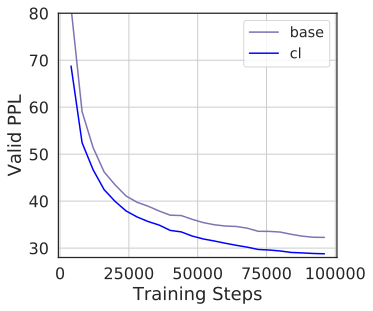

In [33]:
# ploting
trans_base = open('wiki103/cl/base_trans-wt103/log.txt','r').readlines()
trans_base_cl = open('wiki103/cl/cl-trans-base-0503-wt103/log.txt','r').readlines()
valid_ppl_A = []
for line in trans_base:
    if 'valid ppl' in line:
        valid_ppl_A.append(float(line.split('valid ppl')[-1].strip(',').strip()))

valid_ppl_B = []
for line in trans_base_cl:
    if 'valid ppl' in line:
        valid_ppl_B.append(float(line.split('valid ppl')[-1].strip(',').strip()))

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import pylab as pl 
import os
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=[5,4.5])
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
        }

sns.set(style="white")
colors = ['m', 'purple', 'green', 'orange', 'gold', 'blue', 'red']
marks = ['o', 'v', '^', 's', 'D', 'h', '*']
labels = ['insert','delete','substitute','wAEM','sAEM','multi-task model','clean model']

total_data_points = len(valid_ppl_B)
data_xl = np.array(valid_ppl_A)[:total_data_points]
data_sega_xl = np.array(valid_ppl_B)

x_label = list(range(4000,4000*(total_data_points+1),4000))

plt.plot(x_label, data_xl, linestyle='-', c=colors[0], label='base')
plt.plot(x_label, data_sega_xl, linestyle='-', c=colors[5], label='cl')

plt.legend(fontsize='large',loc='best',frameon=True,numpoints=1)
plt.tick_params(labelsize=16)
plt.ylim([28,80])

plt.xlabel('Training Steps', font1)
plt.ylabel('Valid PPL', font1)
plt.grid()
foo_fig = plt.gcf() # 'get current figure'

#foo_fig.savefig('wiki103_valid_ppl.pdf',format='pdf',bbox_inches='tight')
plt.show()  

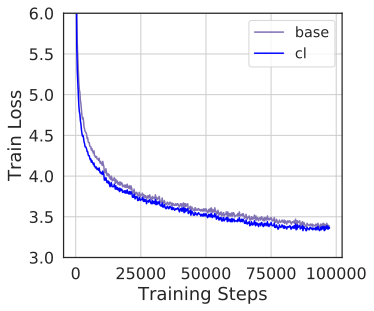

In [32]:
# ploting
trans_base = open('wiki103/cl/base_trans-wt103/log.txt','r').readlines()
trans_base_cl = open('wiki103/cl/cl-trans-base-0503-wt103/log.txt','r').readlines()
train_loss_A = []
for line in trans_base:
    if '| loss' in line:
        train_loss_A.append(float(line.split('|')[-2].strip().split()[-1].strip()))

train_loss_B = []
for line in trans_base_cl:
    if '| loss' in line:
        train_loss_B.append(float(line.split('|')[-2].strip().split()[-1].strip()))

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import pylab as pl 
import os
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=[5,4.5])
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
        }

sns.set(style="white")
colors = ['m', 'purple', 'green', 'orange', 'gold', 'blue', 'red']
marks = ['o', 'v', '^', 's', 'D', 'h', '*']
labels = ['insert','delete','substitute','wAEM','sAEM','multi-task model','clean model']

total_data_points = len(train_loss_B)
data_xl = np.array(train_loss_A)[:total_data_points]
data_sega_xl = np.array(train_loss_B)

x_label = list(range(200,200*(total_data_points+1),200))

plt.plot(x_label, data_xl, linestyle='-', c=colors[0], label='base')
plt.plot(x_label, data_sega_xl, linestyle='-', c=colors[5], label='cl')

plt.legend(fontsize='large',loc='best',frameon=True,numpoints=1)
plt.tick_params(labelsize=16)
plt.ylim([3,6])

plt.xlabel('Training Steps', font1)
plt.ylabel('Train Loss', font1)
plt.grid()
foo_fig = plt.gcf() # 'get current figure'

#foo_fig.savefig('wiki103_valid_ppl.pdf',format='pdf',bbox_inches='tight')
plt.show()  